# Setup

set working directory to guitarist-net and add to path

In [1]:
%cd /content/drive/Othercomputers/My MacBook Pro/guitarist-net

/content/drive/Othercomputers/My MacBook Pro/guitarist-net


install requirements

In [2]:
!pip install -r requirements.txt &> /dev/null

imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
import librosa.display
from plot_listen.listen import play
from plot_listen.plot import plot, plot_single_string_item
from save_load import load_weights_from_file
from util import torch_to_numpy
from globals import *
from data.single_string_dataset import SingleStringDataset
from ddsp.ddsp_mono_synth import DDSPMonoSynth

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# Load Trained Model

create model

In [4]:
synth = DDSPMonoSynth()

load weights

In [5]:
synth.load_state_dict(load_weights_from_file())

Type a number to select an option:
	0)	2022-07-08 08:08PM DDSP Mono Synth : training test
	1)	2022-07-09 01:40PM DDSP Mono Synth : load model and continue training
	2)	2022-07-09 11:45PM DDSP Mono Synth : resume training (third time)
	3)	2022-07-10 10:44AM DDSP Mono Synth : train (4th time)
	4)	2022-07-19 04:05PM DDSP Mono Synth Improved : synth_improvement
	5)	2022-07-19 06:56PM DDSP Mono Synth : train with loudness centered and 32 osc + 32 filter coeffs
	6)	2022-07-20 10:48AM DDSP Mono Synth : train low E
	7)	2022-07-20 12:24PM DDSP Mono Synth Improved : improve 32 param synth - e string
	8)	2022-07-20 07:03PM DDSP Mono Synth : train with lr scheduler
	9)	2022-07-22 11:34AM DDSP Mono Synth : train low E for a while
	10)	2022-07-25 06:42PM DDSP Mono Synth : train with Leaky ReLU
	11)	2022-07-26 04:41PM DDSP Mono Synth : try training with test dataset (one guitarist)
	12)	2022-07-27 06:09PM DDSP Mono Synth : folder deleting, harmonic + noise saving
	13)	2022-07-27 06:12PM DDSP Mono Syn

<All keys matched successfully>

# Load Datasets

get datasets

In [6]:
train_dataset = SingleStringDataset()

Type a number to select an option:
	0)	test_player-00_e-string.npz
	1)	train_player-not00_e-string.npz
	2)	test_player-00_E-string.npz
	3)	train_player-not00_E-string.npz
	4)	test_player-00_solo_E-string.npz
	5)	train_player-not00_solo_E-string.npz
	6)	test_player-00_solo_e-string.npz
	7)	train_player-not00_solo_e-string.npz
Selection: 7
train_player-not00_solo_e-string.npz


In [7]:
test_dataset = SingleStringDataset(loudness_stats=train_dataset.loudness_stats)

Type a number to select an option:
	0)	test_player-00_e-string.npz
	1)	train_player-not00_e-string.npz
	2)	test_player-00_E-string.npz
	3)	train_player-not00_E-string.npz
	4)	test_player-00_solo_E-string.npz
	5)	train_player-not00_solo_E-string.npz
	6)	test_player-00_solo_e-string.npz
	7)	train_player-not00_solo_e-string.npz
Selection: 6
test_player-00_solo_e-string.npz


# Input Data

set index

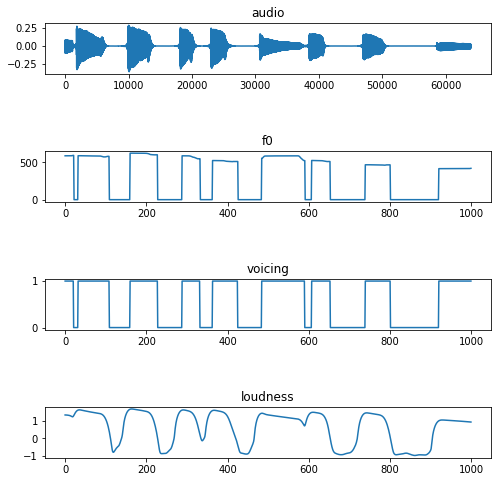

In [8]:
idx = 50
input_data = test_dataset[idx]
plot_single_string_item(input_data)

load f0 + loudness labels

In [9]:
input_f0 = torch.tensor(input_data['f0']).unsqueeze(0) # cast as torch tensor, insert batch size of 1
input_loudness = torch.tensor(input_data['loudness']).unsqueeze(0) # cast as torch tensor, insert batch size of 1

optionally alter inputs

In [10]:
pitch_shift = 3
loudness_scale = 1


input_f0 *= 2**(pitch_shift / 12)
input_loudness *= loudness_scale

feed into model


In [11]:
output = synth.forward(input_f0, input_loudness)

# Examine output

In [12]:
play(output['audio'][0])

### harmonic part

predicted overall amplitude (harmonic part)

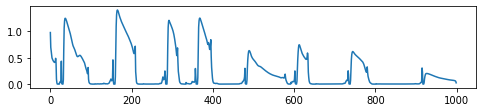

In [13]:
plt.figure(figsize = (8,1.5))
plot(output['overall_amplitude'][0])

predicted harmonic distribution

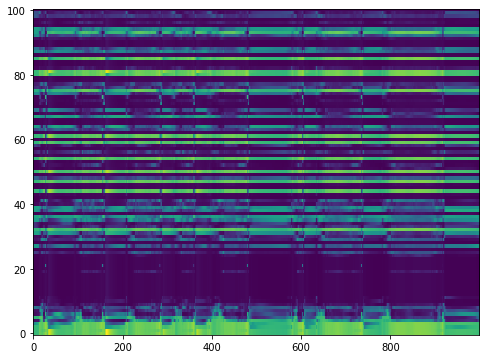

In [14]:
plt.figure(figsize = (8,6))
harm_distr = output['harm_distr'][0]
plt.imshow(torch_to_numpy(harm_distr), aspect='auto', interpolation='none', origin='lower')

predicted harmonic audio

In [15]:
play(output['harmonic'][0])

### noise part

predicted filter coefficients

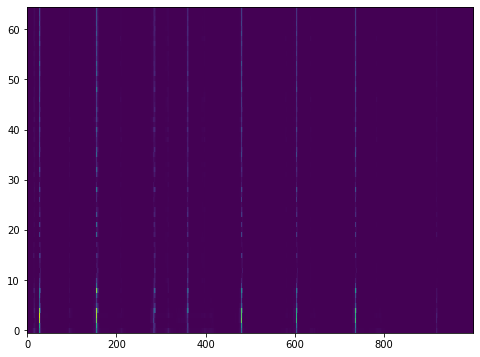

In [16]:
plt.figure(figsize = (8,6))
filter_coeff = output['H'][0].T
plt.imshow(torch_to_numpy(filter_coeff), aspect='auto', interpolation='none', origin='lower');

In [17]:
play(output['noise'][0])

# Compare Original + Resynthesized Audio

show spectrograms

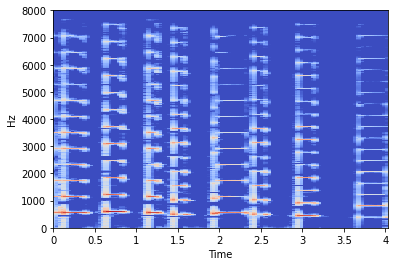

In [18]:
og_audio = input_data['audio']
og_spec = librosa.amplitude_to_db(np.abs(librosa.stft(og_audio)))
og_img = librosa.display.specshow(og_spec, y_axis='linear', x_axis='time', sr=SR)

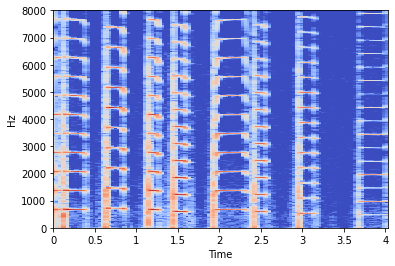

In [19]:
resynth_audio = torch_to_numpy(output['audio'][0])
resynth_spec = librosa.amplitude_to_db(np.abs(librosa.stft(resynth_audio)))
resynth_img = librosa.display.specshow(resynth_spec, y_axis='linear', x_axis='time', sr=SR)

Inspect original audio vs resynthesized

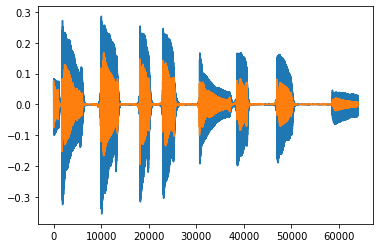

In [20]:
plot(og_audio)
plot(resynth_audio)

In [21]:
print(np.max(og_audio))
print(np.min(og_audio))
print(np.mean(og_audio))

print(np.max(resynth_audio))
print(np.min(resynth_audio))
print(np.mean(resynth_audio))


0.28619042
-0.35531974
-6.633904e-05
0.16831723
-0.19447088
-3.332965e-05


In [27]:
from ddsp.multi_scale_spectral_loss import multi_scale_spectral_loss as my_loss
from ddsp.sweetcocoa_mss import MSSLoss
sc_loss = MSSLoss([2048, 1024, 512, 256], alpha=1.0, overlap=0.75)

In [28]:
og_tensor = torch.tensor(og_audio)
resynth_tensor = torch.tensor(resynth_audio)

In [30]:
print(my_loss(og_tensor, resynth_tensor))
print(sc_loss(og_tensor, resynth_tensor))

tensor(9.3145)
tensor(21.2192)
